author: Diogo Silva

SKL = SciKit-Learn

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%quickref

In [3]:
import seaborn as sns

In [4]:
cd ~/QCThesis/

/home/chiroptera/workspace/QCThesis


In [5]:
from sklearn.cluster import KMeans as KMeans_skl
import MyML.cluster.eac as eac
reload(eac)
import MyML.cluster.K_Means3 as K_Means3
reload(K_Means3)
import MyML.metrics.accuracy as determine_ci
reload(determine_ci)

<module 'MyML.metrics.accuracy' from 'MyML/metrics/accuracy.pyc'>

# Helper functions

In [6]:
def stat_my_kmeans(data,nclusters,gtruth,rounds=20):
    nsamples=data.shape[0]
    all_acc = list()
    for r in xrange(rounds):
        iters="converge"
        kmeans_mode="numpy"

        grouper = K_Means3.K_Means(nclusters=nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "index"
        grouper.fit(data)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(gtruth,grouper.labels_,format='array')
        all_acc.append(accuracy)
        
        
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)
    
def stat_skl_kmeans(data,nclusters,gtruth,rounds=20,init='random'):
    nsamples=data.shape[0]
    all_acc = list()
    for r in xrange(rounds):
        iters="converge"
        kmeans_mode="numpy"

        gSKL = KMeans_skl(n_clusters=nclusters,n_init=1,init=init)
        gSKL.fit(data)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(gtruth,gSKL.labels_,format='array')
        all_acc.append(accuracy)
        
        
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

In [96]:
def k_analysis(partition_files,ground_truth,nprots,iters="converge",rounds=20,files=True):
    nsamples=data.shape[0]
    all_acc = list()
    
    for r in xrange(rounds):
        prot_mode="random"

        estimator=eac.EAC(nsamples)
        estimator.fit(partition_files,files=files,assoc_mode='prot', prot_mode=prot_mode, nprot=nprots,build_only=True)

        kmeans_mode = "numpy"
        nclusters = np.unique(ground_truth).shape[0]

        grouper = K_Means3.K_Means(nclusters=nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "index"
        grouper.fit(estimator._coassoc)

        
        sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
        sklAcc.score(gt,grouper.labels_,format='array')
        
        all_acc.append(sklAcc.accuracy)
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

def k_analysis_better(partition_files,ground_truth,nprots,iters="converge",rounds=20,files=True):
    nsamples=data.shape[0]
    all_acc = list()
    
    for r in xrange(rounds):
        prot_mode="random"

        estimator=eac.EAC(nsamples)
        estimator.fit(partition_files,files=files,assoc_mode='prot', prot_mode=prot_mode, nprot=nprots,build_only=True)

        kmeans_mode = "numpy"
        nclusters = np.unique(ground_truth).shape[0]

        grouper = K_Means3.K_Means(nclusters=nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "iter"
        grouper.fit(estimator._coassoc)

        sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
        sklAcc.score(gt,grouper.labels_,format='array')
        
        all_acc.append(sklAcc.accuracy)
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

def k_skl_analysis(partition_files,ground_truth,nprots,rounds=20,files=True):
    nsamples=data.shape[0]
    all_acc = list()
    
    for r in xrange(rounds):
        prot_mode="random"

        estimator=eac.EAC(nsamples)
        estimator.fit(partition_files,files=files,assoc_mode='prot', prot_mode=prot_mode, nprot=nprots,build_only=True)

        kmeans_mode = "numpy"
        nclusters = np.unique(ground_truth).shape[0]


        grouper = KMeans_skl(n_clusters=nclusters,n_init=1,init="random")
        grouper.fit(estimator._coassoc)
        
        sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
        sklAcc.score(gt,grouper.labels_,format='array')
        
        all_acc.append(sklAcc.accuracy)
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

# Generate data

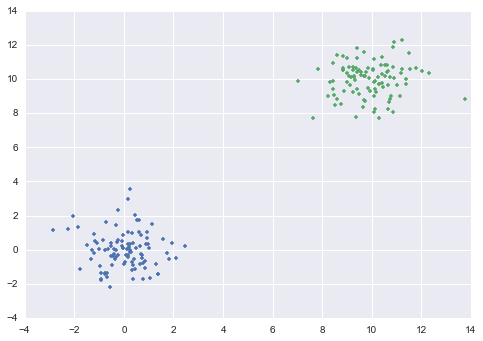

In [8]:
center1=(0,0)
center2=(10,10)

cov1=1
cov2=1

n1=100
n2=100
nsamples=n1+n2
dim=2

g1 = np.random.normal(loc=center1,scale=cov1,size=(n1,dim))
g2 = np.random.normal(loc=center2,scale=cov2,size=(n2,dim))

data = np.vstack((g1,g2))
gt=np.zeros(data.shape[0],dtype=np.int32)
gt[100:]=1

figData=plt.figure()
plt.plot(g1[:,0],g1[:,1],'.')
plt.plot(g2[:,0],g2[:,1],'.')

## Generate partitions, k=6,10,[4,25]

In [9]:
def formatPartition(partition):
    nclusters=np.unique(partition).shape[0]
    finalPartition=[list() for x in xrange(nclusters)]
    for n,c in partition:
        finalPartition[c].append(n)
        
    return finalPartition

def generatePartitions(data,npartitions,nclusters,iters=3):
    
    if type(nclusters) is list:
        clusterRange = True
        min_ncluster=nclusters[0]
        max_ncluster=nclusters[1]
    else:
        clusterRange = False
        k = nclusters
        
    partitions = list()
    
    mode = "numpy"
    for p in xrange(npartitions):
        if clusterRange:
            k = np.random.randint(min_ncluster,max_ncluster)
        
        grouper = K_Means3.K_Means(nclusters=k, iters=iters, mode=mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "index"
        grouper.fit(data)
        partitions.append(grouper.partition)
        
    return partitions
        
def generatePartitionsSKL(data,npartitions,nclusters,iters=3):
    
    if type(nclusters) is list:
        clusterRange = True
        min_ncluster=nclusters[0]
        max_ncluster=nclusters[1]
    else:
        clusterRange = False
        k = nclusters
        
    partitions = list()
    
    mode = "numpy"
    for p in xrange(npartitions):
        if clusterRange:
            k = np.random.randint(min_ncluster,max_ncluster)
        
        gSKL = KMeans_skl(n_clusters=k,n_init=1,init="random",max_iter=iters)
        gSKL.fit(data)
        partitions.append(formatPartition(gSKL.labels_))
        
    return partitions
    

In [10]:
npartitions=30
iters=3

nclusters=10
partitions_my_10 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl_10 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

if type(nclusters) is not list:
    allGood=True
    for p in xrange(npartitions):
        if len(partitions_my_10[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_my_10[p]))
            allGood=False
        if len(partitions_skl_10[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_skl_10[p]))
            allGood=False
    if allGood:
        print 'All partitions have good number of clusters.'

nclusters=6
partitions_my_6 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl_6 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

if type(nclusters) is not list:
    allGood=True
    for p in xrange(npartitions):
        if len(partitions_my_6[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_my_6[p]))
            allGood=False
        if len(partitions_skl_6[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_skl_6[p]))
            allGood=False
    if allGood:
        print 'All partitions have good number of clusters.'

nclusters=[4,25]
partitions_my_rand = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl_rand = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

if type(nclusters) is not list:
    allGood=True
    for p in xrange(npartitions):
        if len(partitions_my_rand[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_my[p]))
            allGood=False
        if len(partitions_skl_rand[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_skl[p]))
            allGood=False
    if allGood:
        print 'All partitions have good number of clusters.'

All partitions have good number of clusters.
All partitions have good number of clusters.


# EAC K-Means

## 6 clusters per partition

My Accuracy:	1.0
SKL Accuracy:	1.0


MyML/helper/partition.py:56: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if clusts == None:


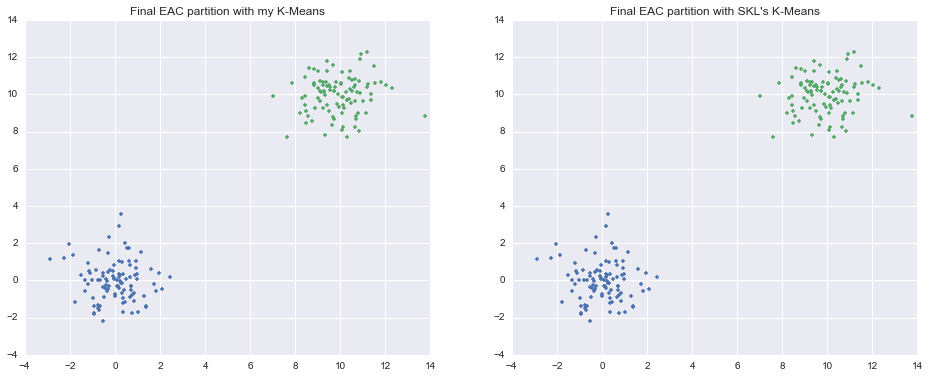

In [11]:
# generate coassoc
prot_mode="random"
assoc_mode='full' # prot or full
nprots=nsamples # number of prototypes

partitions_used = partitions_my_10

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# cluster with my K-Means
kmeans_mode = "numpy"

grouper = K_Means3.K_Means(nclusters=true_nclusters, iters="converge", mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
grouper._centroid_mode = "index"
grouper.fit(myEstimator._coassoc)

# cluster with SKL K-Means
gSKL = KMeans_skl(n_clusters=true_nclusters,n_init=1,init="random")
gSKL.fit(myEstimator._coassoc)

# Hungarian accuracy
myAcc = determine_ci.HungarianIndex(nsamples=nsamples)
myAcc.score(gt,grouper.labels_,format='array')

sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
sklAcc.score(gt,gSKL.labels_,format='array')


print 'My Accuracy:\t',myAcc.accuracy
print 'SKL Accuracy:\t',sklAcc.accuracy

figEAC=plt.figure(figsize=(16,6))
ax1EAC=figEAC.add_subplot(1,2,1)
ax2EAC=figEAC.add_subplot(1,2,2)

for c in np.unique(grouper.labels_):
    clusterData=grouper.labels_==c
    ax1EAC.plot(data[clusterData,0],data[clusterData,1],'.')
ax1EAC.set_title("Final EAC partition with my K-Means")

for c in np.unique(gSKL.labels_):
    clusterData=gSKL.labels_==c
    ax2EAC.plot(data[clusterData,0],data[clusterData,1],'.')
ax2EAC.set_title("Final EAC partition with SKL's K-Means")

In [12]:
def accuracy(labels1,labels2):
    sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
    sklAcc.score(labels1,labels2,format='array')
    return sklAcc.accuracy

In [13]:
def seek_bad_coassoc(data,rounds=20):
    for r in xrange(rounds):
        nclusters = 3

        grouper = K_Means3.K_Means(nclusters=nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "index"
        try:
            grouper.fit(data)
        except:
            print "iterations={}".format(grouper.iters_)
            return estimator
        
    return None

In [19]:
test_c=myEstimator._coassoc[[1,1]]

In [20]:
myEstimator._coassoc

array([[ 30.,   1.,   2., ...,   0.,   0.,   0.],
       [  1.,  30.,   1., ...,   0.,   0.,   0.],
       [  2.,   1.,  30., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,  30.,   0.,   4.],
       [  0.,   0.,   0., ...,   0.,  30.,   8.],
       [  0.,   0.,   0., ...,   4.,   8.,  30.]])

In [21]:
gSKL = KMeans_skl(n_clusters=2,n_init=1,init="random",max_iter=1)
gSKL.fit(myEstimator._coassoc)
accuracy(gt,gSKL.labels_)

1.0

In [23]:
reload(K_Means3)

<module 'MyML.cluster.K_Means3' from 'MyML/cluster/K_Means3.pyc'>

In [56]:
#%%timeit
grouper = K_Means3.K_Means(nclusters=2, iters="converge", mode="numpy", cuda_mem='manual',tol=1e-4,max_iters=300,centroids="random")
grouper.fit(myEstimator._coassoc)
accuracy(gt,grouper.labels_)

1.0

In [88]:
grouper = K_Means3.K_Means(nclusters=2, iters="converge", mode="numpy", cuda_mem='manual',tol=1e-5,max_iters=300,centroids="random")
grouper._centroid_mode = "iter"
grouper.fit(myEstimator._coassoc)
accuracy(gt,grouper.labels_)

1.0

In [97]:
partitions_used=partitions_my_rand
print k_skl_analysis(partitions_used,gt,nsamples,rounds=100,files=False)
print k_analysis_better(partitions_used,gt,nsamples,rounds=100,files=False)
print k_analysis(partitions_used,gt,nsamples,rounds=100,files=False)

(1.0, 0.0, 1.0, 1.0)
(1.0, 0.0, 1.0, 1.0)
(1.0, 0.0, 1.0, 1.0)


In [356]:
def _np_label_fast(data,centroids):

    N,D = data.shape
    C,cD = centroids.shape

    labels = np.zeros(N,dtype=np.int32)

    # first iteration of all datapoints outside loop
    # distance from points to centroid 0
    best_dist = data - centroids[0]
    best_dist = best_dist ** 2
    best_dist = best_dist.sum(axis=1) 


    for c in xrange(1,C):
        # distance from points to centroid c
        dist = data - centroids[c]
        dist = dist ** 2
        dist = dist.sum(axis=1)

        #thisCluster = np.full(N,c,dtype=np.int32)
        #labels = np.where(dist < bestd_ist,thisCluster,labels)
        labels[dist<best_dist] = c
        best_dist = np.minimum(dist,best_dist)

    return labels

In [358]:
labels=_np_label_fast(saved_est._coassoc,test_c)

In [369]:
labelChangedIndex = np.where(labels[1:] != labels[:-1])[0] + 1

In [371]:
labelChangedIndex.size

0

In [277]:
bad_est=seek_bad_coassoc(saved_est._coassoc,rounds=10000)
print bad_est == None

labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
centroids:  [[  2.   1.   0.   0.   0.   0.   5.   0.   2.   0.   0.   0.   0.   0.
    1.   0.  21.   1.   0.   0.   0.   0.   1.  17.   0.   0.   2.  16.
    0.  30.   0.   2.   0.   1.   0.   7.   0.   0.   0.   1.   0.   1.
    1.   0.   0.  30.   0.   4.   0.   1.   0.   1.   0.  22.   4.   0.
    0.   5.   3.   8.   0.   0.   4.   0.   1.   0.   0.   0.  13.   3.
    1.   0.   0.   1.   0.   0.   0.   0.   0.   3.   2.   0.  30.   1.
    2.  19.  20.   0.   0.   2.   0.   6.   0.   1.   0.   0.   2.   0.
    1.   0.   0.   0.   0.   0.   0.   8.   0.  21.   0.  14.   1.  

Accuracy is usually 100% in both cases (clustering from my K-Means and SciKit-Learn's). This depends on the ensemble. For some ensembles the accuracy on both is always one, for others it sometimes is not in one or both of the K-Means used (mine vs SKL).

The number of prototypes is equal to the number of samples and since there are not repeated prototypes, all the samples are being used. Above are the visualizations of the solutions. 

### Statistic analysis

In [107]:
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "skl \t",
for metric in k_skl_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100):
    print "{}\t".format(metric),
print "\nmy  \t",
for metric in k_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,iters="converge",rounds=100):
    print "{}\t".format(metric),


type	mean	var	max	min
skl 	0.97345	0.0044723475	1.0	0.76	
my  	0.90525	0.0098911875	1.0	0.715	

In [108]:
print "\nmy  \t",
for metric in k_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,iters="converge",rounds=100):
    print "{}\t".format(metric),


my  	0.90835	0.0090310275	1.0	0.725	

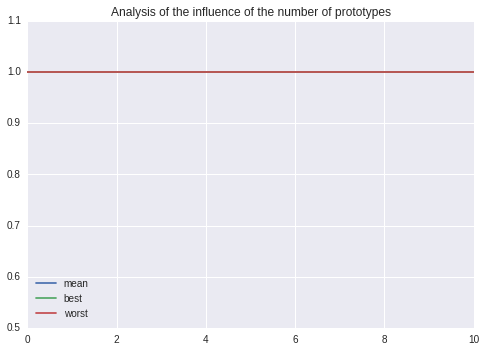

In [14]:
nprots=[5,20,40,60,80,100,120,140,160,180,200]

results_k10=list()
for n in nprots:
    r=k_skl_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100)
    results_k10.append(r)
    
mean_k10=[res[0] for res in results_k10]
var_k10=[res[1] for res in results_k10]
best_k10=[res[2] for res in results_k10]
worst_k10=[res[3] for res in results_k10]

plt.plot(mean_k10,label='mean')
plt.plot(best_k10,label='best')
plt.plot(worst_k10,label='worst')
plt.plot([0, 10], [0.5, 0.5], 'k-', lw=1)
plt.title("Analysis of the influence of the number of prototypes")
plt.legend(loc='best')

## 10 clusters per partition

My Accuracy:	0.7
SKL Accuracy:	1.0

Statistical analysis
type	mean	var	max	min
skl 	0.93705	0.0112285475	1.0	0.685	
my  	0.87935	0.0097233275	1.0	0.675	

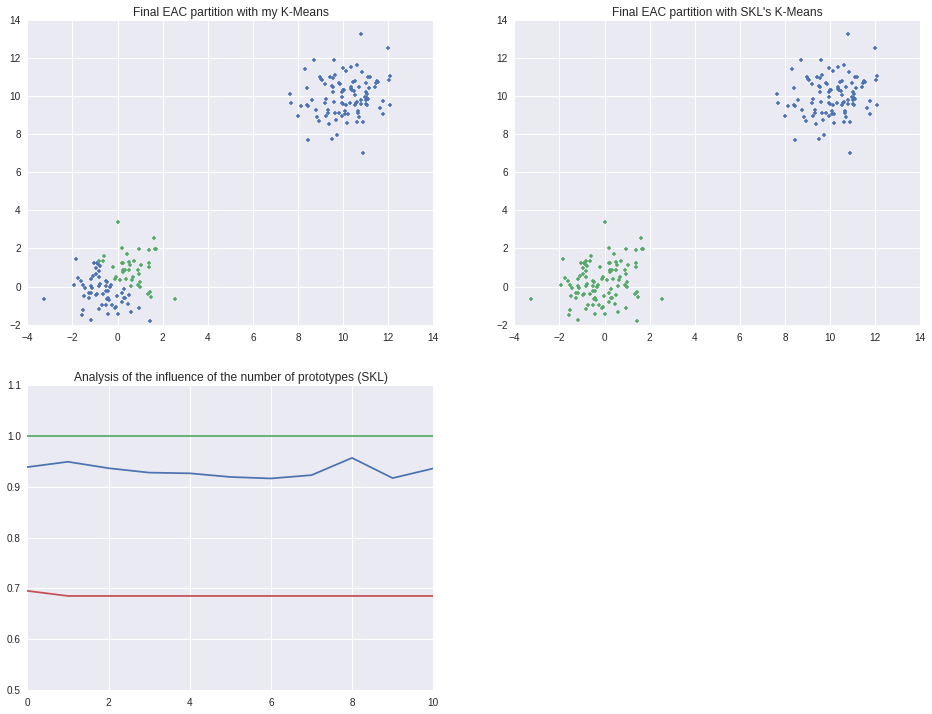

In [15]:
partitions_used = partitions_my_10

# generate coassoc
prot_mode="random"
assoc_mode='prot' # prot or full
nprots=nsamples # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# cluster with my K-Means
kmeans_mode = "numpy"

grouper = K_Means3.K_Means(nclusters=true_nclusters, iters="converge", mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
grouper._centroid_mode = "index"
grouper.fit(myEstimator._coassoc)

# cluster with SKL K-Means
gSKL = KMeans_skl(n_clusters=true_nclusters,n_init=1,init="random")
gSKL.fit(myEstimator._coassoc)

# Hungarian accuracy
myAcc = determine_ci.HungarianIndex(nsamples=nsamples)
myAcc.score(gt,grouper.labels_,format='array')

sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
sklAcc.score(gt,gSKL.labels_,format='array')


print 'My Accuracy:\t',myAcc.accuracy
print 'SKL Accuracy:\t',sklAcc.accuracy

figEAC2=plt.figure(figsize=(16,12))
ax1EAC2=figEAC2.add_subplot(2,2,1)
ax2EAC2=figEAC2.add_subplot(2,2,2)
ax3EAC2=figEAC2.add_subplot(2,2,3)

for c in np.unique(grouper.labels_):
    clusterData=grouper.labels_==c
    ax1EAC2.plot(data[clusterData,0],data[clusterData,1],'.')
ax1EAC2.set_title("Final EAC partition with my K-Means")

for c in np.unique(gSKL.labels_):
    clusterData=gSKL.labels_==c
    ax2EAC2.plot(data[clusterData,0],data[clusterData,1],'.')
ax2EAC2.set_title("Final EAC partition with SKL's K-Means")

nprots=[5,20,40,60,80,100,120,140,160,180,200]
results_k6=list()
for n in nprots:
    r=k_skl_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100)
    results_k6.append(r)
    
mean_k6=[res[0] for res in results_k6]
var_k6=[res[1] for res in results_k6]
best_k6=[res[2] for res in results_k6]
worst_k6=[res[3] for res in results_k6]

ax3EAC2.plot(mean_k6)
ax3EAC2.plot(best_k6)
ax3EAC2.plot(worst_k6)
ax3EAC2.plot([0, 10], [0.5, 0.5], 'k-', lw=1)
ax3EAC2.set_title("Analysis of the influence of the number of prototypes (SKL)")

print "\nStatistical analysis"
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "skl \t",
for metric in k_skl_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100):
    print "{}\t".format(metric),
print "\nmy  \t",
for metric in k_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,iters="converge",rounds=100):
    print "{}\t".format(metric),

## Random number of clusters per partition

My Accuracy:	0.905
SKL Accuracy:	1.0

Statistical analysis
type	mean	var	max	min
skl 	0.954	0.008803	1.0	0.695	
my  	0.91935	0.0116068275	1.0	0.675	

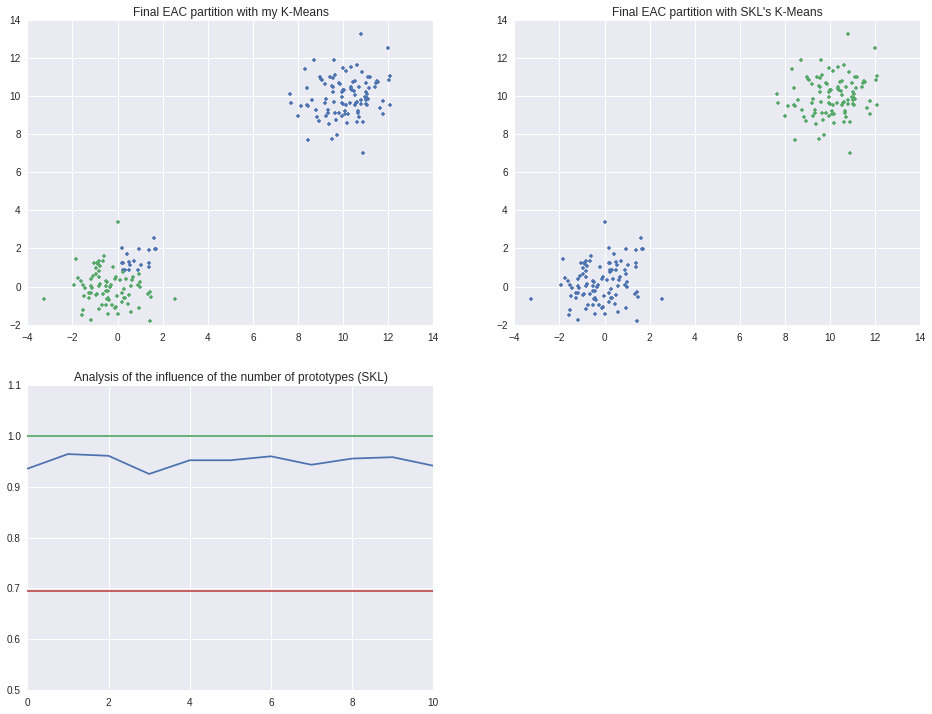

In [16]:
partitions_used = partitions_my_rand

# generate coassoc
prot_mode="random"
assoc_mode='prot' # prot or full
nprots=nsamples # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# cluster with my K-Means
kmeans_mode = "numpy"

grouper = K_Means3.K_Means(nclusters=true_nclusters, iters="converge", mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
grouper._centroid_mode = "index"
grouper.fit(myEstimator._coassoc)

# cluster with SKL K-Means
gSKL = KMeans_skl(n_clusters=true_nclusters,n_init=1,init="random")
gSKL.fit(myEstimator._coassoc)

# Hungarian accuracy
myAcc = determine_ci.HungarianIndex(nsamples=nsamples)
myAcc.score(gt,grouper.labels_,format='array')

sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
sklAcc.score(gt,gSKL.labels_,format='array')


print 'My Accuracy:\t',myAcc.accuracy
print 'SKL Accuracy:\t',sklAcc.accuracy

figEAC2=plt.figure(figsize=(16,12))
ax1EAC2=figEAC2.add_subplot(2,2,1)
ax2EAC2=figEAC2.add_subplot(2,2,2)
ax3EAC2=figEAC2.add_subplot(2,2,3)

for c in np.unique(grouper.labels_):
    clusterData=grouper.labels_==c
    ax1EAC2.plot(data[clusterData,0],data[clusterData,1],'.')
ax1EAC2.set_title("Final EAC partition with my K-Means")

for c in np.unique(gSKL.labels_):
    clusterData=gSKL.labels_==c
    ax2EAC2.plot(data[clusterData,0],data[clusterData,1],'.')
ax2EAC2.set_title("Final EAC partition with SKL's K-Means")

nprots=[5,20,40,60,80,100,120,140,160,180,200]
results_k6=list()
for n in nprots:
    r=k_skl_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100)
    results_k6.append(r)
    
mean_k6=[res[0] for res in results_k6]
var_k6=[res[1] for res in results_k6]
best_k6=[res[2] for res in results_k6]
worst_k6=[res[3] for res in results_k6]

ax3EAC2.plot(mean_k6)
ax3EAC2.plot(best_k6)
ax3EAC2.plot(worst_k6)
ax3EAC2.plot([0, 10], [0.5, 0.5], 'k-', lw=1)
ax3EAC2.set_title("Analysis of the influence of the number of prototypes (SKL)")

print "\nStatistical analysis"
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "skl \t",
for metric in k_skl_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100):
    print "{}\t".format(metric),
print "\nmy  \t",
for metric in k_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,iters="converge",rounds=100):
    print "{}\t".format(metric),

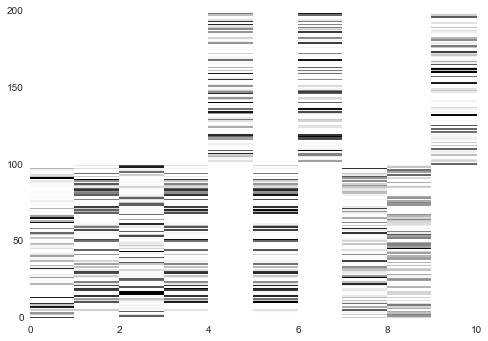

In [159]:
plt.pcolor(myEstimator._coassoc)

# K-Means only

In [18]:
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "my  \t",
for metric in stat_my_kmeans(data,true_nclusters,gt,rounds=100):
    print "{}\t".format(metric),
print "\nskl \t",
for metric in stat_skl_kmeans(data,true_nclusters,gt,rounds=100):
    print "{}\t".format(metric),

type	mean	var	max	min
my  	1.0	0.0	1.0	1.0	
skl 	1.0	0.0	1.0	1.0	

# EAC K-Medoids

In [19]:
import MyML.cluster.KMedoids as KMedoids

## 6 clusters per partition

In [36]:
#%%debug
partitions_used = partitions_my_6

# generate coassoc
prot_mode="random"
assoc_mode='full' # prot or full
nprots=50 # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# compute diassociation from co-assoc
diassoc=myEstimator._coassoc.max()-myEstimator._coassoc

#k-medoids
labels,medoids=KMedoids.cluster(diassoc,k=true_nclusters)

# Hungarian accuracy
acc = determine_ci.HungarianIndex(nsamples=nsamples)
acc.score(gt,labels,format='array')

print 'K-Medoids Accuracy:\t',acc.accuracy

K-Medoids Accuracy:	1.0


### Statistical analysis

In [22]:
class acc_medoids():
    def __init__(self,data,nclusters,gt):
        self.data=data
        self.nsamples=data.shape[0]
        self.nclusters=nclusters
        self.gt=gt
        
    def run(self):
        labels,medoids=KMedoids.cluster(self.data,k=self.nclusters)
        # Hungarian accuracy
        acc = determine_ci.HungarianIndex(nsamples=self.nsamples)
        acc.score(self.gt,labels,format='array')
        return acc.accuracy
    
class acc_skl_kmeans():
    def __init__(self,data,nclusters,gt):
        self.data=data
        self.nclusters=nclusters
        self.nsamples=data.shape[0]
        self.gt=gt
    def run(self):
        # cluster with SKL K-Means
        gSKL = KMeans_skl(n_clusters=self.nclusters,n_init=1,init="random")
        gSKL.fit(self.data)

        # Hungarian accuracy
        sklAcc = determine_ci.HungarianIndex(nsamples=self.nsamples)
        sklAcc.score(self.gt,gSKL.labels_,format='array')
        
        return sklAcc.accuracy

def stat_analysis(method,rounds=20):
    rAll = np.zeros(rounds)
    for r in xrange(rounds):
        rAll[r]=method.run()
    return rAll.mean(),rAll.var(),rAll.max(),rAll.min()

In [23]:
rounds=100
diassoc=myEstimator._coassoc.max()-myEstimator._coassoc
x=acc_medoids(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmedoids\t',stat_analysis(x,rounds=rounds)

x2=acc_skl_kmeans(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmeans  \t',stat_analysis(x2,rounds=rounds)

x3=acc_medoids(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmedoids  \t',stat_analysis(x3,rounds=rounds)

x4=acc_skl_kmeans(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmeans    \t',stat_analysis(x4,rounds=rounds)

diassoc kmedoids	(1.0, 0.0, 1.0, 1.0)
diassoc kmeans  	(1.0, 0.0, 1.0, 1.0)
assoc kmedoids  	(0.87944999999999995, 0.016268947499999999, 0.98999999999999999, 0.65500000000000003)
assoc kmeans    	(1.0, 0.0, 1.0, 1.0)


## 10 clusters per partition

In [27]:
#%%debug
partitions_used = partitions_my_10

# generate coassoc
prot_mode="random"
assoc_mode='full' # prot or full
nprots=50 # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# compute diassociation from co-assoc
diassoc=myEstimator._coassoc.max()-myEstimator._coassoc

#k-medoids
labels,medoids=KMedoids.cluster(diassoc,k=true_nclusters)

# Hungarian accuracy
acc = determine_ci.HungarianIndex(nsamples=nsamples)
acc.score(gt,labels,format='array')

print 'K-Medoids Accuracy:\t',acc.accuracy

K-Medoids Accuracy:	0.79


### Statistical analysis

In [28]:
rounds=100
diassoc=myEstimator._coassoc.max()-myEstimator._coassoc
x=acc_medoids(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmedoids\t',stat_analysis(x,rounds=rounds)

x2=acc_skl_kmeans(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmeans  \t',stat_analysis(x2,rounds=rounds)

x3=acc_medoids(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmedoids  \t',stat_analysis(x3,rounds=rounds)

x4=acc_skl_kmeans(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmeans    \t',stat_analysis(x4,rounds=rounds)

diassoc kmedoids	(0.88564999999999983, 0.006913827499999998, 0.98999999999999999, 0.70999999999999996)
diassoc kmeans  	(0.94109999999999983, 0.007578790000000001, 1.0, 0.68500000000000005)
assoc kmedoids  	(0.80559999999999998, 0.0076446399999999994, 0.98999999999999999, 0.57999999999999996)
assoc kmeans    	(0.93274999999999997, 0.0096581875000000036, 1.0, 0.68500000000000005)


## Random clusters per partition

In [29]:
#%%debug
npartitions=30
nclusters=[4,25]
iters=3
partitions_used = partitions_my_rand

# generate coassoc
prot_mode="random"
assoc_mode='full' # prot or full
nprots=50 # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# compute diassociation from co-assoc
diassoc=myEstimator._coassoc.max()-myEstimator._coassoc

#k-medoids
labels,medoids=KMedoids.cluster(diassoc,k=true_nclusters)

# Hungarian accuracy
acc = determine_ci.HungarianIndex(nsamples=nsamples)
acc.score(gt,labels,format='array')

print 'K-Medoids Accuracy:\t',acc.accuracy

K-Medoids Accuracy:	1.0


### Statistical analysis

In [30]:
rounds=100
diassoc=myEstimator._coassoc.max()-myEstimator._coassoc
x=acc_medoids(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmedoids\t',stat_analysis(x,rounds=rounds)

x2=acc_skl_kmeans(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmeans  \t',stat_analysis(x2,rounds=rounds)

x3=acc_medoids(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmedoids  \t',stat_analysis(x3,rounds=rounds)

x4=acc_skl_kmeans(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmeans    \t',stat_analysis(x4,rounds=rounds)

diassoc kmedoids	(1.0, 0.0, 1.0, 1.0)
diassoc kmeans  	(0.94669999999999999, 0.0095141100000000044, 1.0, 0.69499999999999995)
assoc kmedoids  	(0.86844999999999994, 0.019944347500000001, 0.98999999999999999, 0.59999999999999998)
assoc kmeans    	(0.93619999999999992, 0.011716560000000003, 1.0, 0.69499999999999995)


In [31]:
from sklearn.metrics.pairwise import pairwise_distances

In [32]:
pairwise=pairwise_distances(data)
y=acc_medoids(pairwise,2,gt=gt)
stat_analysis(y,rounds=20)

(1.0, 0.0, 1.0, 1.0)

# EAC Single link

In [1]:
#%%debug
npartitions=30
nclusters=[4,25]
iters=3
partitions_used = partitions_my_rand

# generate coassoc
prot_mode="random"
assoc_mode='full' # prot or full
nprots=50 # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

#k-medoids
myEstimator._apply_linkage()
labels = myEstimator._clusterFromLinkage()

# Hungarian accuracy
acc = determine_ci.HungarianIndex(nsamples=nsamples)
acc.score(gt,labels,format='array')

print 'K-Medoids Accuracy:\t',acc.accuracy

NameError: name 'partitions_my_rand' is not defined

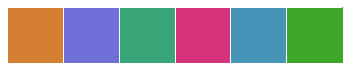

In [34]:
#generated from: http://tools.medialab.sciences-po.fr/iwanthue/
my_colors=["#D37E30",
"#6F6FD8",
"#3AA579",
"#D5337B",
"#4595B8",
"#3EA729",
"#D150D7",
"#4E6E23",
"#8F4D79",
"#D64430",
"#A1952B",
"#C15257",
"#AA5BB3",
"#6A76B0",
"#8E5723",
"#2A7464",
"#D66C9F",
"#60994E",
"#73A32D",
"#33A74F"]
my_pallete=sns.color_palette(my_colors)
sns.palplot(my_pallete)
sns.set_palette(my_pallete)

In [35]:
figX=sns.plt.figure(figsize=(12,90))
for i,p in enumerate(partitions_skl):
    ax=figX.add_subplot(15,2,i+1)
    for c in p:
        ax.plot(data[c,0],data[c,1],'.',markersize=12)
        ax.set_title("partition {}".format(i+1))

NameError: name 'partitions_skl' is not defined